In [1]:
import h5py, sys, os
import numpy as np
from scipy.special import j1
from scipy.signal import hilbert2
from scipy import ndimage
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from datetime import datetime
from pyhank import HankelTransform
from matplotlib import colors
print(os.getcwd())

%matplotlib widget

from jfunctions import *

# Get directory locations from param file
base_dir, run_dir, save_dir, version = read_params("./params.dat")

# Load simulation metadata
md = get_metadata()

# Load grids
gxf, gyf, gzf, dzf = get_grid(md)
gx, gy, gz, dz = get_grid(md, fractional_grid=False)

print(base_dir)

/mhome/damtp/q/cwp29/diablo3/proc/jupyter/waves
/store/ATMOS/cwp29/data/waves/wide/hres/N_1/


In [2]:
#Load simulation data
var1, times = load_data('w_xz')
NSAMP = len(times)

times, t0_idx = calibrate_time(save_dir, times)

print(version)
if version == "3.12":
    buoy_per = round(2*np.pi/np.sqrt(md['N2']),1)
    md['TIME_LIMIT'] = (md['FINE_RES_TIME'] + md['NBUOY_PERIODS'])*buoy_per
    md['SAVE_STATS_DT'] *= buoy_per
    md['SAVE_STATS_DT_FINE'] *= buoy_per
    tend_idx = len(times)-1
    tstart_idx = get_index(md['FINE_RES_TIME']*buoy_per, times)
    print(md['TIME_LIMIT'], md['FINE_RES_TIME']*buoy_per)
    print("Time range: {0:.2f} to {1:.2f} s".format(times[tstart_idx], times[tend_idx]))
    print("equal to {0:.2f} buoyancy periods".format((times[tend_idx]-times[tstart_idx])/buoy_per))
else:
    tstart_idx = get_index(5, times)
    tend_idx = get_index(15, times)

#zplot = 0.4
zmin = 0.3
zmax = 0.5
zmin_idx = get_index(zmin, gzf)
zmax_idx = get_index(zmax, gzf)

var1_filtered = np.zeros_like(var1)

for i in range(NSAMP):
    var1_filtered[i] = ndimage.gaussian_filter(var1[i], 1)

waves = var1_filtered[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, :]

#plt.figure()
#plt.plot(waves)
#plt.show()

print(var1.shape)
print(waves.shape)


Keys: <KeysViewHDF5 ['epsilon_xy', 'epsilon_xz', 'epsilon_yz', 'kappa_t1_xy', 'kappa_t1_xz', 'kappa_t1_yz', 'kappa_t2_xy', 'kappa_t2_xz', 'kappa_t2_yz', 'nlwf_xz', 'nu_t_xy', 'nu_t_xz', 'nu_t_yz', 'omegaX_xy', 'omegaX_xz', 'omegaX_yz', 'omegaY_xy', 'omegaY_xz', 'omegaY_yz', 'omegaZ_xy', 'omegaZ_xz', 'omegaZ_yz', 'th1_xy', 'th1_xz', 'th1_yz', 'th2_xy', 'th2_xz', 'th2_yz', 'u_xy', 'u_xz', 'u_yz', 'v_xy', 'v_xz', 'v_yz', 'w_xy', 'w_xz', 'w_yz']>
Plume penetration occured at t=2.3545
3.12
25.2 6.3
Time range: 6.30 to 25.07 s
equal to 2.98 buoyancy periods
(156, 513, 1024)
(150, 172, 1024)


In [3]:
print(md)

{'LX': 1.0, 'LY': 1.0, 'LZ': 0.6, 'RE': 10000000000.0, 'nu': 1e-10, 'SAVE_MOVIE_DT': 0.25, 'SAVE_STATS_DT': 1.575, 'NU_START': 1e-07, 'SAVE_FLOW_DT': 50.0, 'VERSION': 3.12, 'NU_START_TIME': 50.0, 'SAVE_STATS_DT_FINE': 0.126, 'FINE_RES_TIME': 1.0, 'TIME_LIMIT': 25.2, 'NBUOY_PERIODS': 3.0, 'r0': 0.005, 'alpha_e': 0.1, 'b0': 0.2, 'Lyc': 0.02, 'Lyp': 0.01, 'S_depth': 0.1, 'N2': 1.0, 'H': 0.2, 'b_factor': 0.4, 'Nb': 256.0, 'Nphi': 256.0, 'F_TYPE': 3.0, 'Nx': 1024, 'Ny': 1024, 'Nz': 513, 'Nth': 2}


In [4]:
waves_t = np.fft.fft(waves, axis=0) # time FFT
freq_m = -np.fft.fftfreq(tend_idx-tstart_idx+1)*2*np.pi/md['SAVE_STATS_DT_FINE']
waves_t[freq_m <= 0, :, :] = 0 # zero out negative freq.
waves_t *= 2 # preserve energy

wavesHT = np.fft.ifft(waves_t, axis=0)

waves_txz = np.fft.fft2(wavesHT) # spatial FFT
print(waves_txz.shape)

wavenumber_z = np.fft.fftfreq(waves.shape[1])*2*np.pi*md['Nz']/md['LZ']
wavenumber_x = np.fft.fftfreq(waves.shape[2])*2*np.pi*md['Nx']/md['LX']

waves_right = np.copy(waves_txz)
waves_left = np.copy(waves_txz)
#waves_txz[:, wavenumber_z >= 0, :] = 0 # isolate waves
waves_txz[:, :, wavenumber_x >= 0] = 0 # isolate waves
waves_txz[:, wavenumber_z >= 0, :] = 0 # isolate waves
#waves_txz[:, wavenumber_z > 25*np.min(wavenumber_z[wavenumber_z > 0]), :] = 0
#waves_txz[:, :, wavenumber_x > 25*np.min(wavenumber_x[wavenumber_x > 0])] = 0

wavesHT = np.fft.ifft2(waves_txz)

print(wavesHT.shape)

(150, 172, 1024)
(150, 172, 1024)


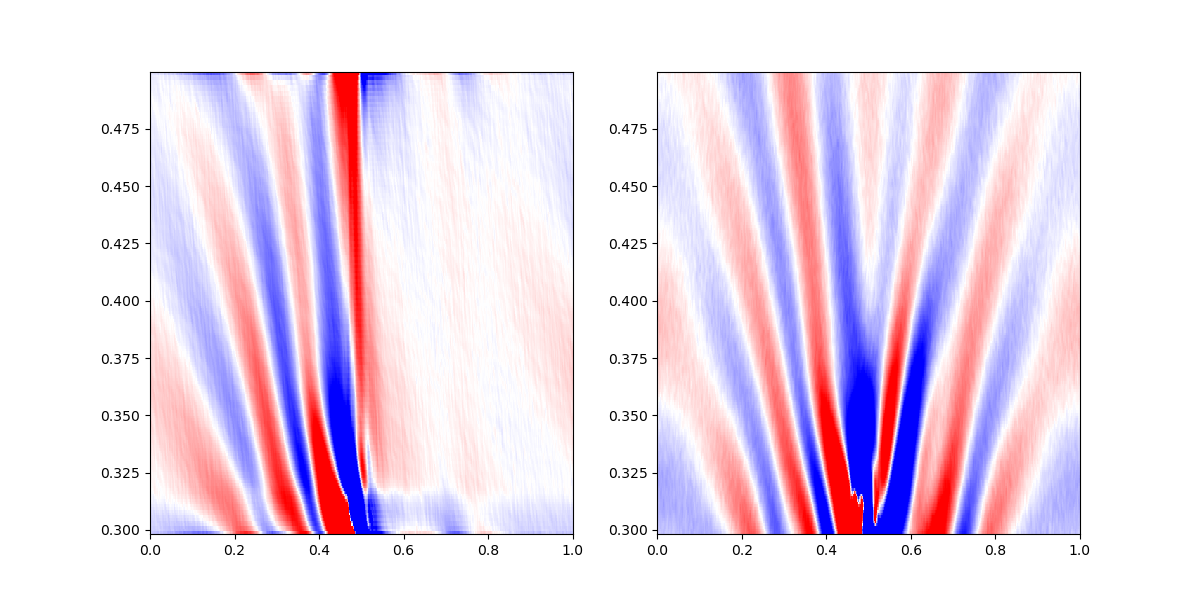

In [5]:
fig, ax = plt.subplots(1,2, figsize=(12, 6))

times_trunc = np.concatenate(([times[tstart_idx]-md['SAVE_STATS_DT_FINE']], times[tstart_idx:tend_idx+1]))
X, Y = np.meshgrid(gx, gz[zmin_idx-1:zmax_idx+1])
im_filtered = ax[0].pcolormesh(X, Y, np.real(wavesHT[-1]), cmap='bwr', norm=colors.CenteredNorm())
im_orig = ax[1].pcolormesh(X, Y, waves[-1], cmap='bwr', norm=colors.CenteredNorm())

im_filtered.set_clim(-1e-1*np.max(np.real(wavesHT[-1])), 1e-1*np.max(np.real(wavesHT[-1])))
im_orig.set_clim(-1e-1*np.max(np.real(waves[-1])), 1e-1*np.max(np.real(waves[-1])))
plt.show()


Setting up data arrays...
Setting up initial plot...
Initialising mp4 writer...
Starting plot...


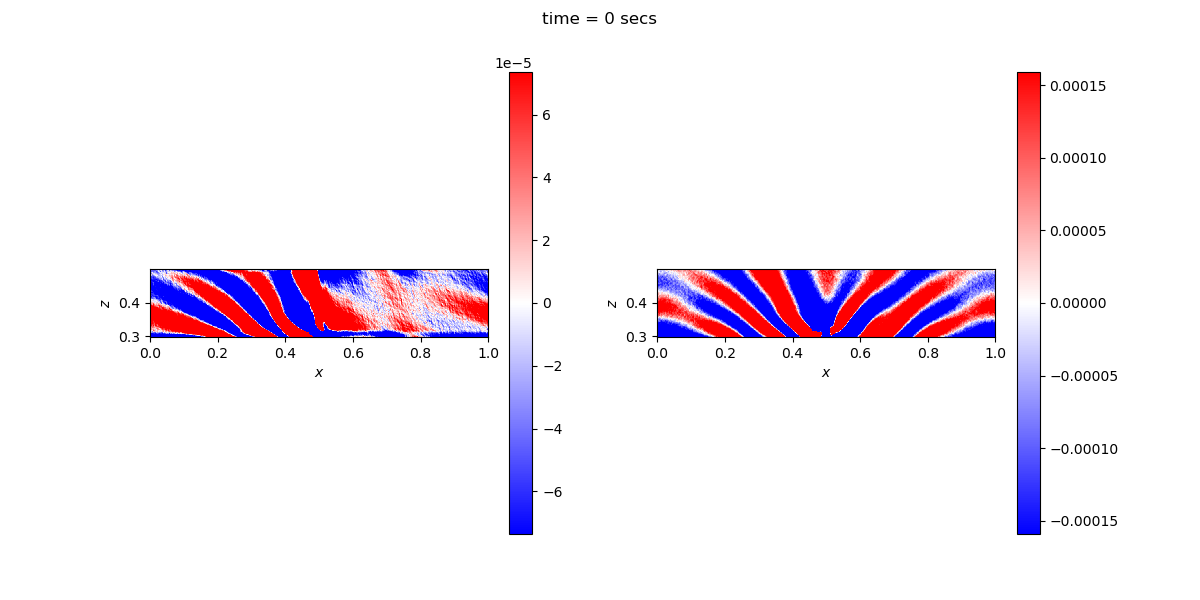

In [6]:
print("Setting up data arrays...")
fig, axs = plt.subplots(1,2, figsize=(12,6))
ims = np.array([None,None])
cb = np.array([None,None])

print("Setting up initial plot...")
ims[0] = axs[0].pcolormesh(X, Y, np.real(wavesHT[-1]), cmap='bwr', norm=colors.CenteredNorm())
ims[1] = axs[1].pcolormesh(X, Y, waves[-1], cmap='bwr', norm=colors.CenteredNorm())

cb[0] = plt.colorbar(ims[0],ax=axs[0])
cb[1] = plt.colorbar(ims[1],ax=axs[1])

ims[0].set_clim(1e-2*np.max(np.real(wavesHT)), 1e-2*np.max(np.real(wavesHT)))
ims[1].set_clim(1e-2*np.max(np.real(waves)), 1e-2*np.max(np.real(waves)))

fig.suptitle("time = 0 secs")
axs[0].set_ylabel("$z$")
axs[1].set_ylabel("$z$")
axs[0].set_xlabel("$x$")
axs[1].set_xlabel("$x$")

axs[0].set_aspect(1)
axs[1].set_aspect(1)

def animate(step):
    ims[0].set_array(np.real(wavesHT[step]).ravel())
    ims[1].set_array(waves[step].ravel())
    fig.suptitle("time = {0:.2f} secs".format(times_trunc[step]))

    return ims.flatten(),

print("Initialising mp4 writer...")
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, bitrate=1800)

print("Starting plot...")
anim = animation.FuncAnimation(fig, animate, interval=500, frames=tend_idx+1-tstart_idx, repeat=True)
now = datetime.now()
plt.show()

(150, 1024)


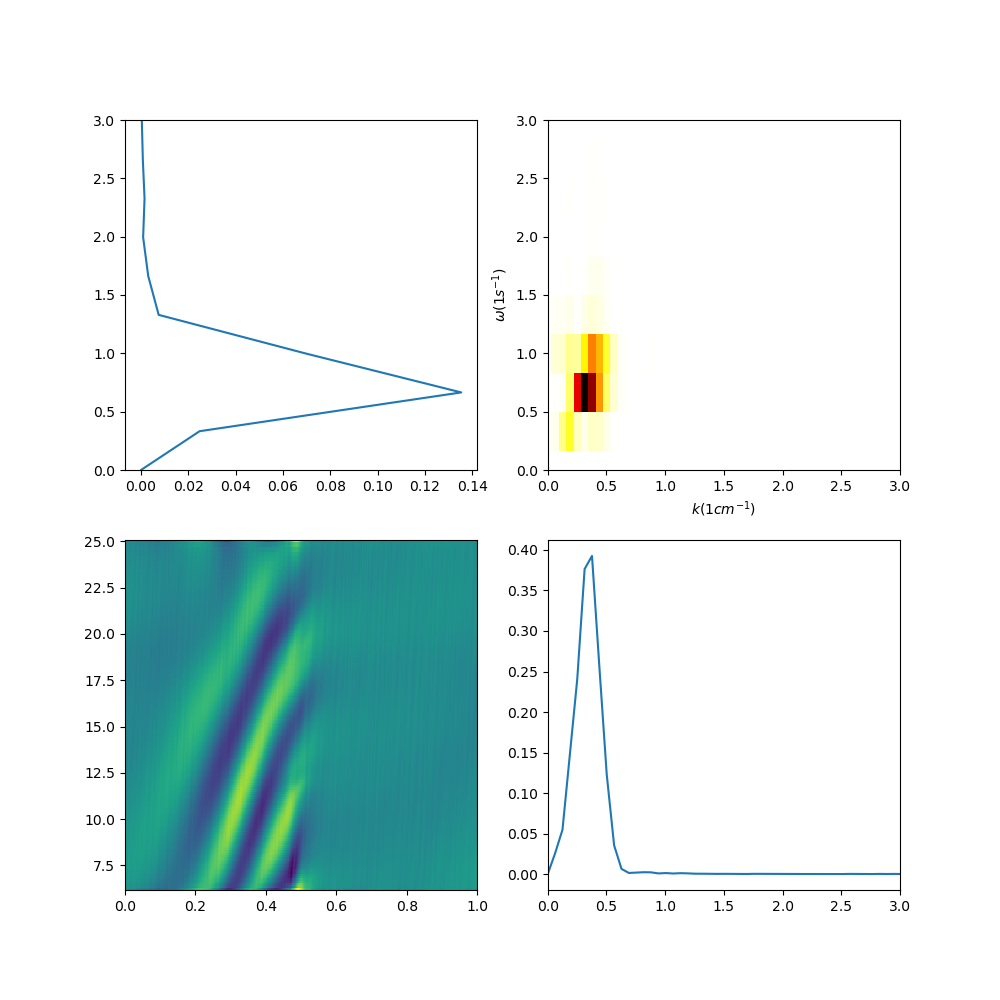

In [7]:
# Plot frequency and wavenumber spectra
zplot = 0.4
gzf_trunc = gzf[zmin_idx:zmax_idx+1]

stacked_data = np.real(wavesHT[:, get_index(zplot, gzf_trunc), :])
stacked_data = np.flip(stacked_data, axis=0) # flip data
print(stacked_data.shape)

stacked_ft = np.fft.fft2(stacked_data)
stacked_ft = np.fft.fftshift(stacked_ft)
freq = np.fft.fftfreq(stacked_data.shape[0])*2*np.pi/md['SAVE_STATS_DT_FINE']
freq = np.fft.fftshift(freq)
wavenumber = -np.fft.fftfreq(stacked_data.shape[1])*2*np.pi*md['Nx']/md['LX']
wavenumber = np.fft.fftshift(wavenumber)

power = np.power(np.abs(stacked_ft), 2)

X, Y = np.meshgrid(wavenumber/100, freq)

fig2, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,1].pcolormesh(X, Y, power, cmap='hot_r')
ax[0,1].set_xlabel(r"$k (1 cm^{-1})$")
ax[0,1].set_ylabel(r"$\omega (1 s^{-1})$")
ax[0,1].set_xlim(0, 3)
ax[0,1].set_ylim(0, 3)

X, Y = np.meshgrid(gx, times_trunc)
ax[1,0].pcolormesh(X, Y, stacked_data)
#ax[1,0].set_xlim(0, 20)
#ax[1,0].set_ylim(7.5, 25)

ax[0,0].plot(np.mean(power, axis=1), freq)
ax[0,0].set_ylim(0, 3)

ax[1,1].plot(wavenumber/100, np.mean(power, axis=0))
ax[1,1].set_xlim(0, 3)
plt.show()
